# IMPORTING NECESSEARY LIBRARIES

In [1105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, train_test_split


In [1106]:
df= pd.read_excel("/Users/hanishka_kela/Documents/Healthcare_Premium_Prediction_(Regression)/Data_resources/premiums.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [1107]:
df.shape

(50000, 13)

# DATA CLEANING


In [1108]:
df.columns=df.columns.str.replace(' ','_').str.lower()

In [1109]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [1110]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

# HANDLE NA VALUES

In [1111]:
df.dropna(inplace=True)

In [1112]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

# CHECKING FOR DUPLICATES

In [1113]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [1114]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [1115]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

In [1116]:
df['number_of_dependants']=abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [1117]:
numeric_coloumns = df.select_dtypes(include='number').columns
numeric_coloumns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

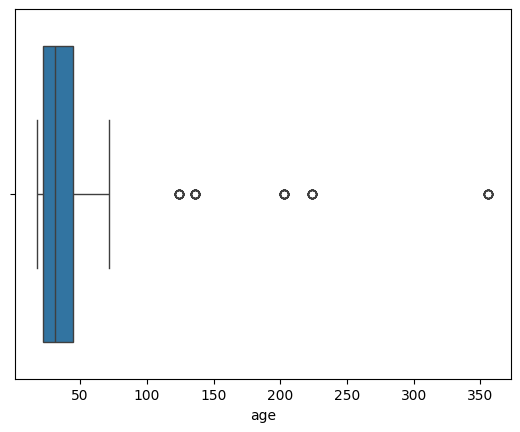

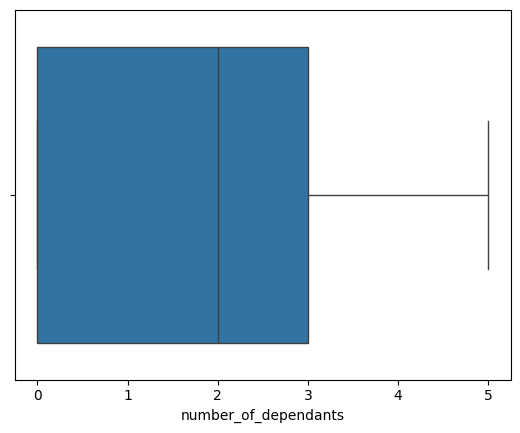

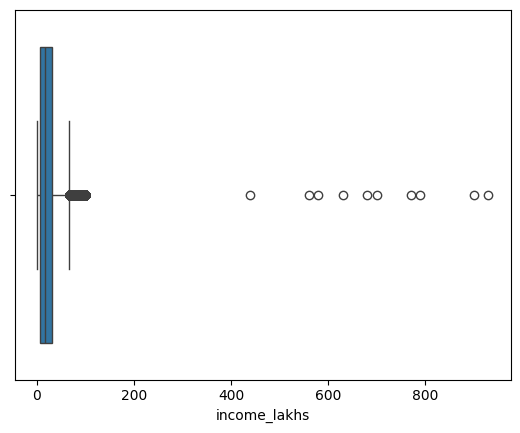

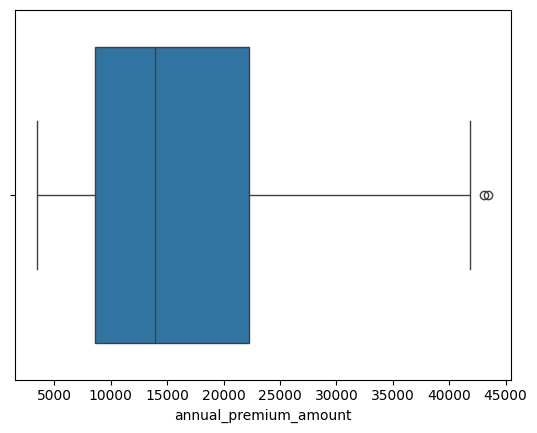

In [1118]:
for col in numeric_coloumns:
    sns.boxplot(x=df[col])
    plt.show()

In [1119]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [1120]:
df1=df[df.age<=100].copy()
df1.describe()


,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


In [1121]:
def get_iqr_bounds(col):
    Q1, Q3=col.quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound , upper_bound

get_iqr_bounds(df1.income_lakhs)


(-29.0, 67.0)

In [1122]:
qunatile_threshold= df1.income_lakhs.quantile(0.999)
qunatile_threshold

np.float64(100.0)

In [1123]:
df2 = df1[df1.income_lakhs<=qunatile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


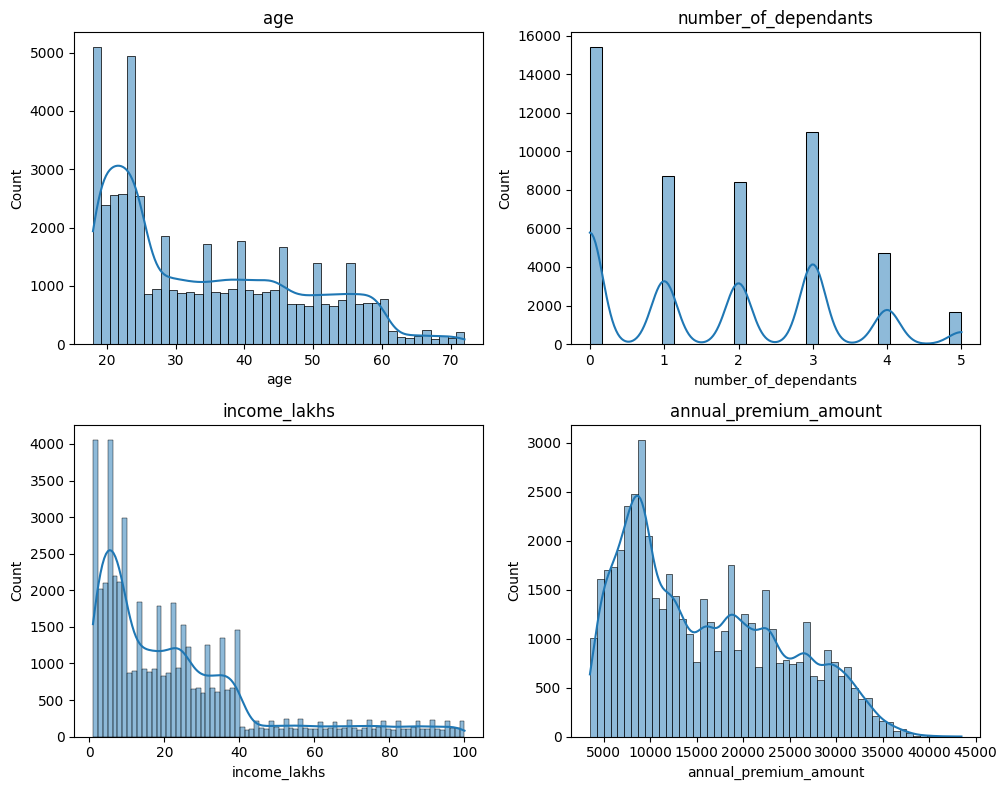

In [1124]:
fig, axs=plt.subplots(nrows=2,ncols=2,figsize=(10,8))

for i,col in enumerate(numeric_coloumns):
    ax=axs[i//2,i%2]
    sns.histplot(df2[col],kde=True,ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

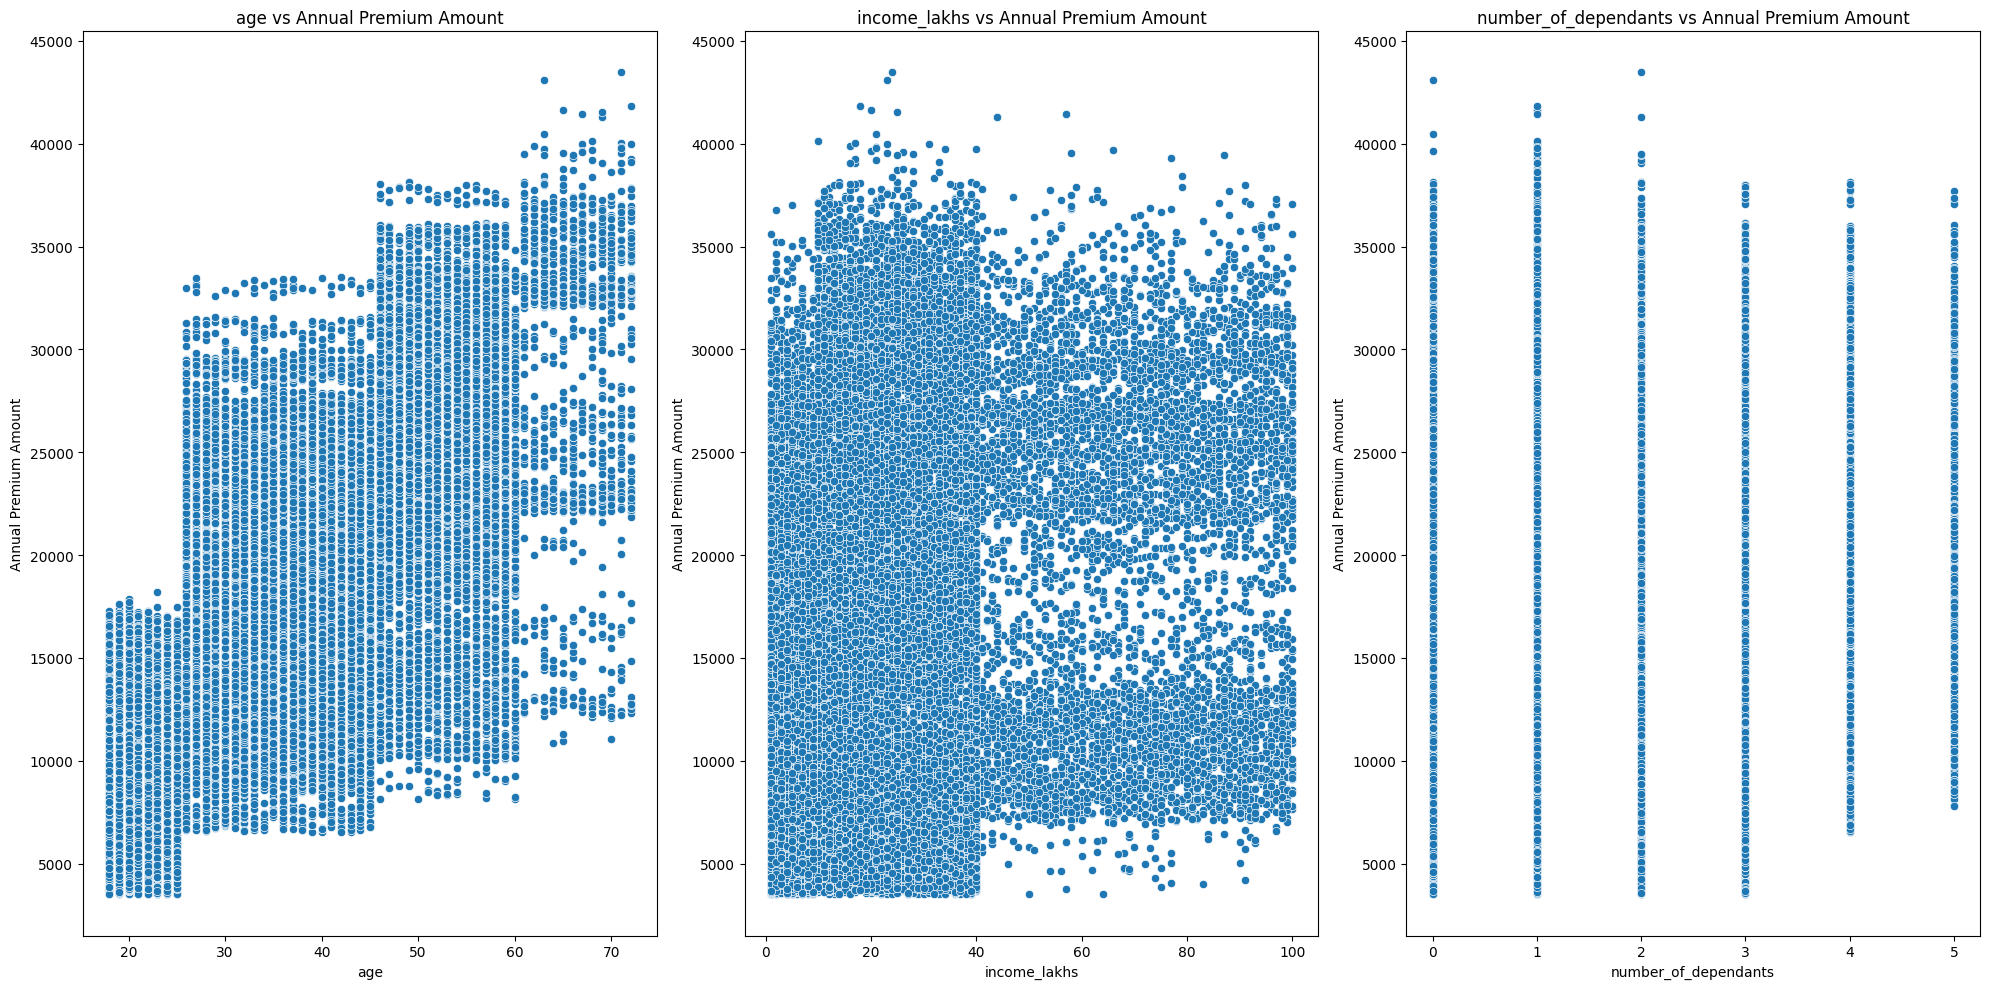

In [1125]:
numeric_features=['age','income_lakhs','number_of_dependants']

fig,axes=plt.subplots(1,len(numeric_features),figsize=(20,10))
for ax, col in zip(axes, numeric_features):
    sns.scatterplot(x=df2[col],y=df2['annual_premium_amount'],ax=ax)
    ax.set_title(f'{col} vs Annual Premium Amount')
    ax.set_xlabel(col)
    ax.set_ylabel("Annual Premium Amount")

plt.tight_layout()
plt.show()

In [1126]:
categorical_cols=df.select_dtypes(include=['object', 'category', 'bool']).columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [1127]:
for col in categorical_cols:
    print(col,' : ',df2[col].unique() )

gender  :  ['Male' 'Female']
region  :  ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status  :  ['Unmarried' 'Married']
bmi_category  :  ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status  :  ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status  :  ['Salaried' 'Self-Employed' 'Freelancer']
income_level  :  ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history  :  ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan  :  ['Bronze' 'Silver' 'Gold']


In [1128]:
df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking':'No Smoking'
},inplace=True)

df2['smoking_status'].unique()

/var/folders/r_/zhk06phn5rg0kd9cv4qb47140000gn/T/ipykernel_16974/691254365.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [1129]:
pct_count=df2['gender'].value_counts(normalize=True)

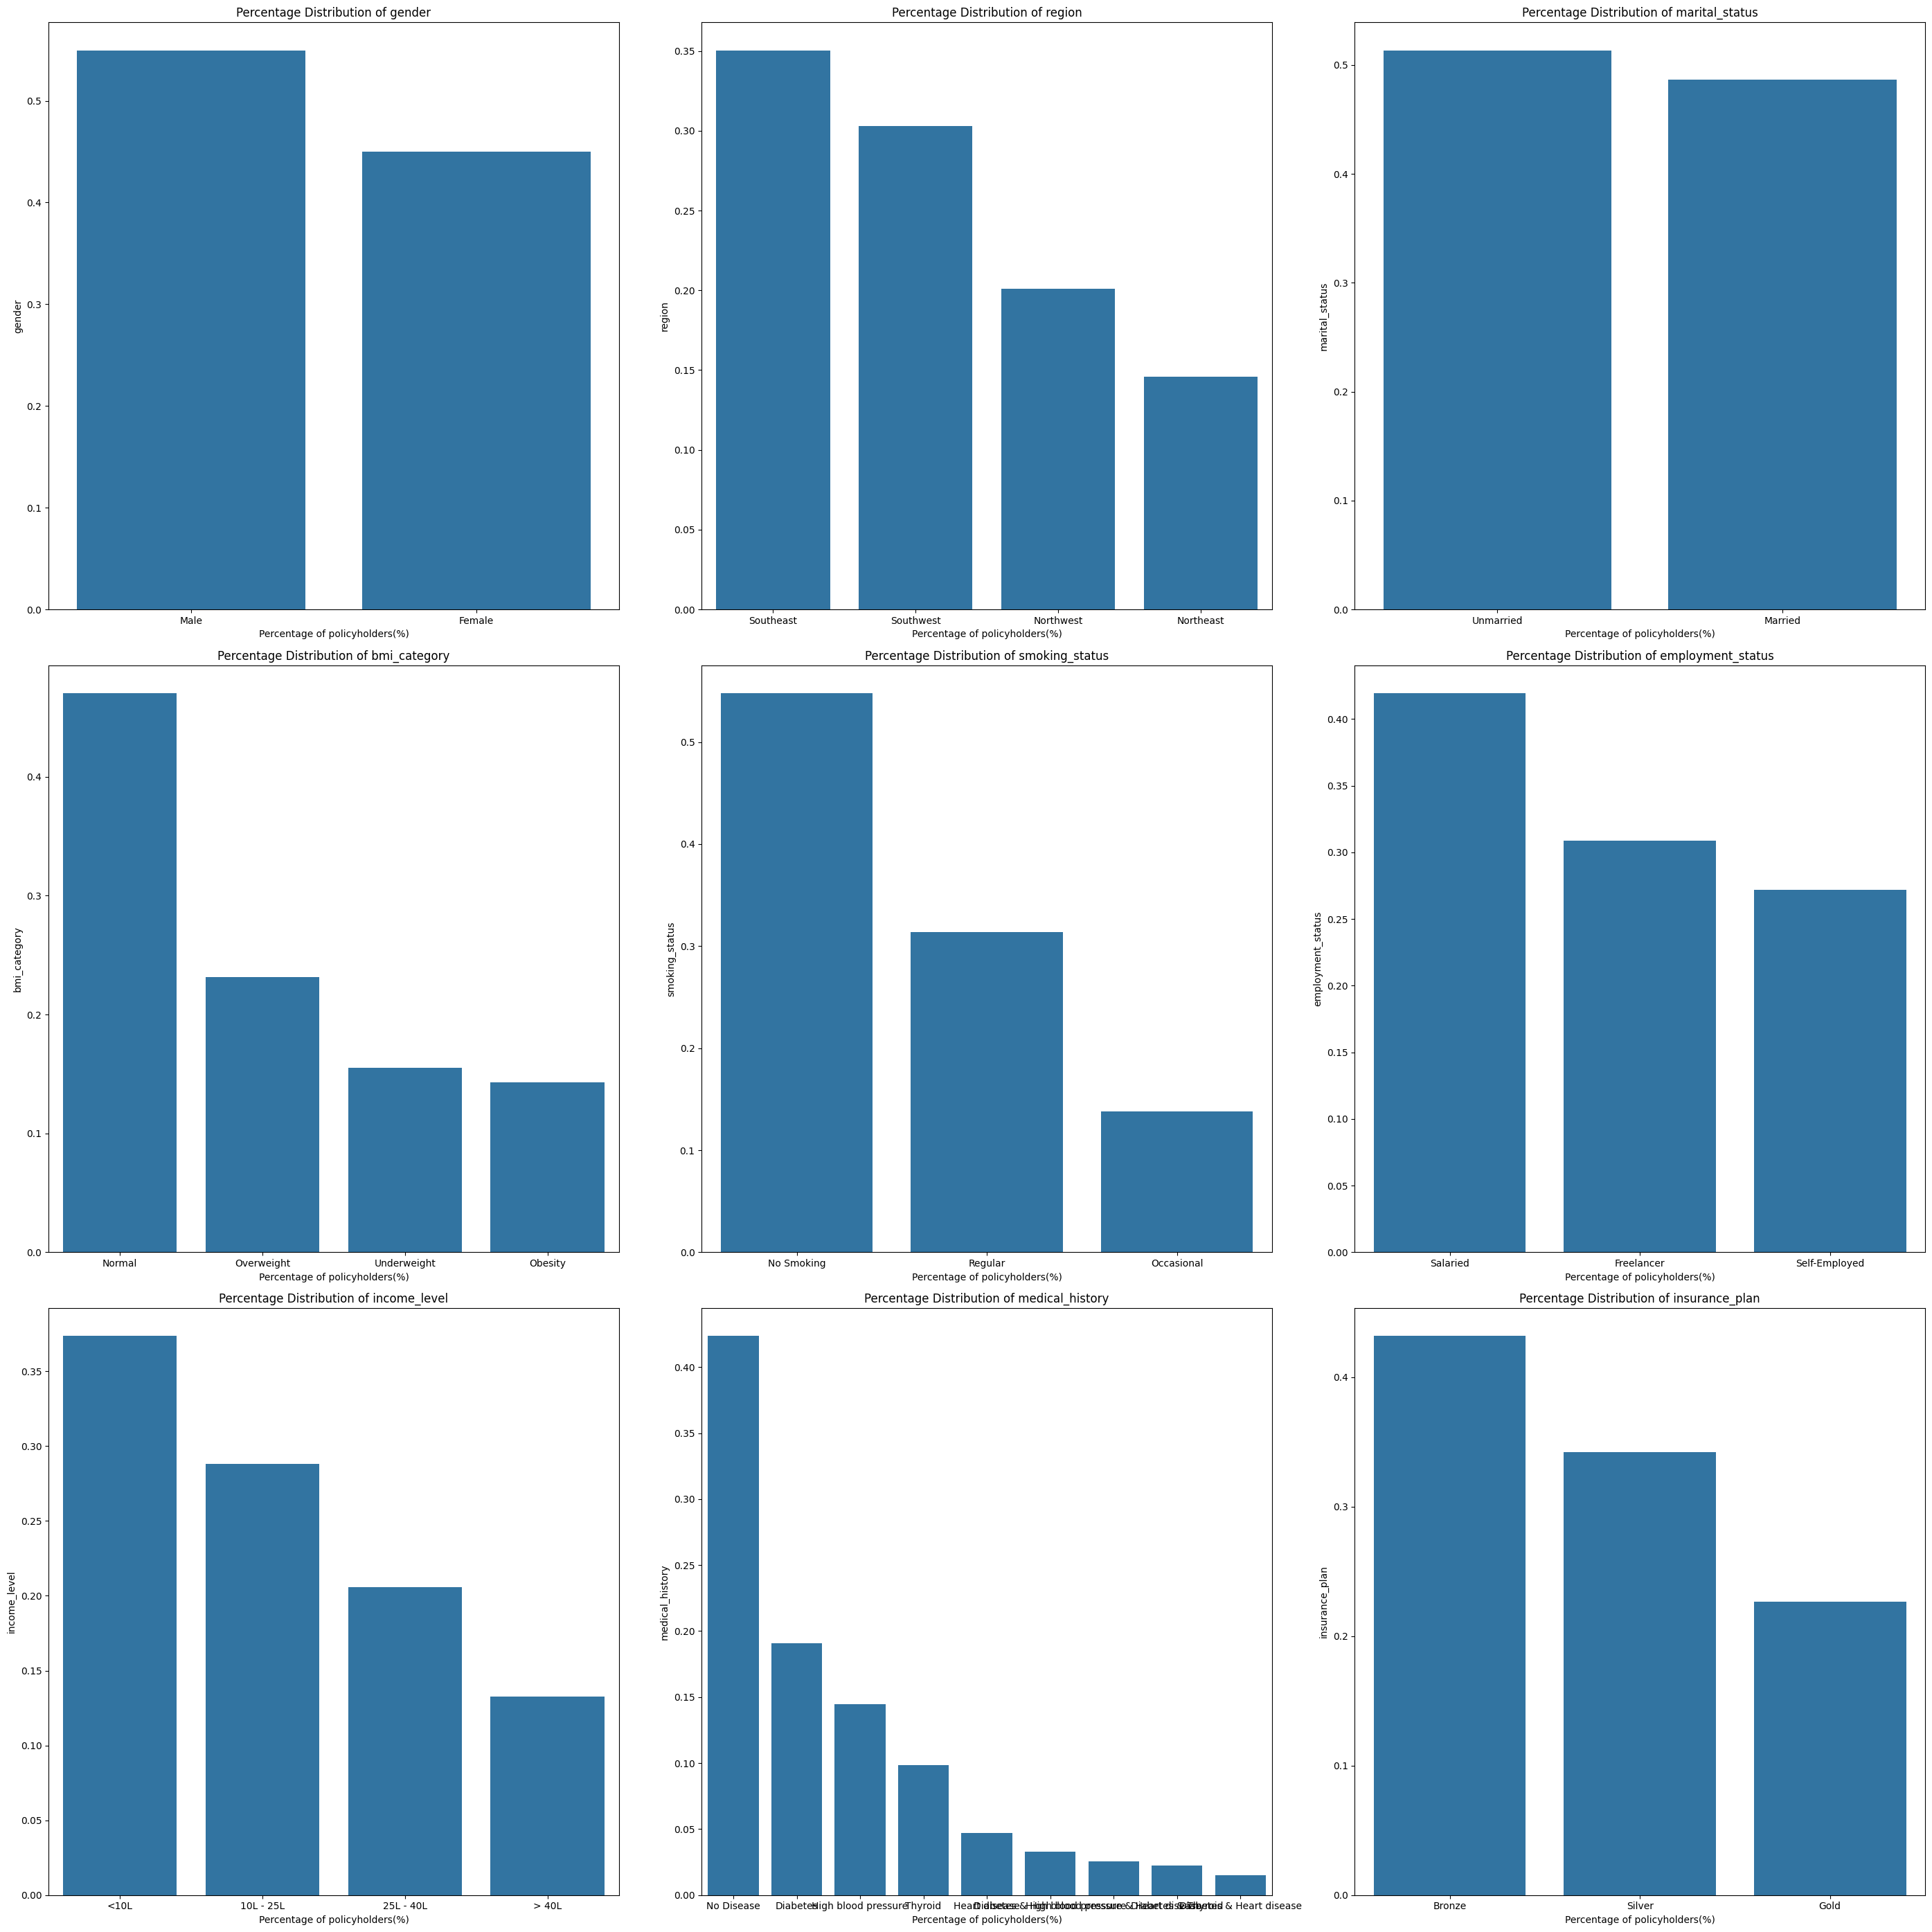

In [1130]:
fig, axes=plt.subplots(3,3,figsize=(28,28))
axes=axes.flatten()
for ax, col in zip(axes, categorical_cols):
    category_counts=df2[col].value_counts(normalize=True)
    sns.barplot(x=category_counts.index,y=category_counts.values,ax=ax)
    ax.set_title(f'Percentage Distribution of {col}')
    ax.set_xlabel("Percentage of policyholders(%)")
    ax.set_ylabel(col)
plt.tight_layout()
plt.show()    

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


<Axes: xlabel='income_level'>

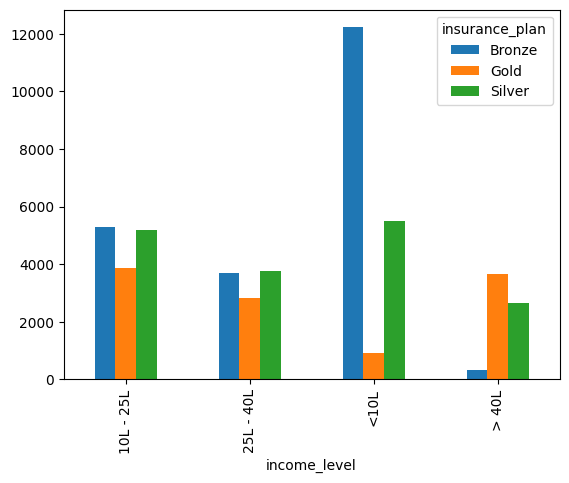

In [1131]:
crosstab=pd.crosstab(df2['income_level'],df2['insurance_plan'])
print(crosstab)
crosstab.plot(kind='bar')

<Axes: xlabel='insurance_plan', ylabel='income_level'>

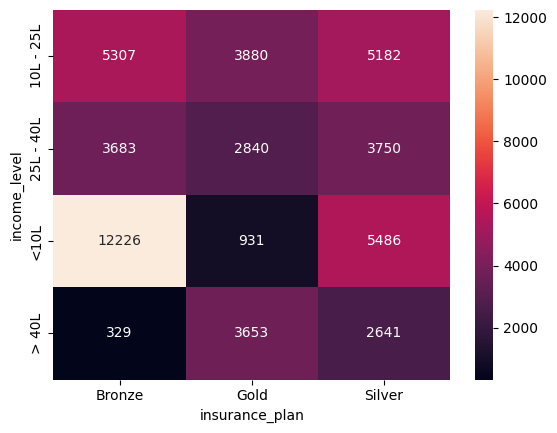

In [1132]:
sns.heatmap(crosstab,annot=True,fmt='d')

# FEATURE ENGINEERING 

In [1133]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [1134]:
risk_scores={
    'diabetes':6,
    'heart disease':8,
    'high blood pressure':6,
    'thyroid':5,
    'no disease':0,
    'none':0
}

df2[['disease1','disease2']]= df2['medical_history'].str.split(' & ',expand =True).apply(lambda x:x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None


In [1135]:
df2['disease1'].fillna('none',inplace=True)
df2['disease2'].fillna('none',inplace=True)
df2['total_risk_score']=0

for disease in['disease1','disease2']:
    df2['total_risk_score']+=df2[disease].map(risk_scores)

max_score=df2['total_risk_score'].max()
min_score=df2['total_risk_score'].min()
df2['normalized_risk_score']=(df2['total_risk_score']-min_score)/(max_score-min_score)
df2.head()

/var/folders/r_/zhk06phn5rg0kd9cv4qb47140000gn/T/ipykernel_16974/308706082.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none',inplace=True)
/var/folders/r_/zhk06phn5rg0kd9cv4qb47140000gn/T/ipykernel_16974/308706082.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571


In [1136]:
df2.sample(15)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
45674,18,Male,Southwest,Unmarried,1,Underweight,Regular,Salaried,10L - 25L,15,High blood pressure,Bronze,8904,high blood pressure,none,6,0.428571
20193,53,Female,Northwest,Married,3,Normal,No Smoking,Self-Employed,25L - 40L,38,Thyroid,Gold,27081,thyroid,none,5,0.357143
39054,35,Male,Northwest,Married,3,Overweight,Regular,Self-Employed,10L - 25L,23,High blood pressure,Silver,20610,high blood pressure,none,6,0.428571
43338,23,Male,Southwest,Unmarried,0,Normal,No Smoking,Self-Employed,10L - 25L,10,No Disease,Bronze,7422,no disease,none,0,0.000000
19564,23,Female,Southwest,Unmarried,0,Normal,Regular,Self-Employed,25L - 40L,40,No Disease,Bronze,5839,no disease,none,0,0.000000
46443,33,Male,Northeast,Unmarried,0,Normal,No Smoking,Salaried,<10L,9,High blood pressure,Bronze,8858,high blood pressure,none,6,0.428571
967,18,Female,Northwest,Unmarried,2,Overweight,No Smoking,Salaried,10L - 25L,11,No Disease,Bronze,6472,no disease,none,0,0.000000
30069,33,Female,Southwest,Married,2,Normal,No Smoking,Salaried,10L - 25L,20,High blood pressure,Bronze,9319,high blood pressure,none,6,0.428571
14686,36,Female,Southeast,Unmarried,1,Normal,No Smoking,Salaried,<10L,5,High blood pressure,Silver,15961,high blood pressure,none,6,0.428571
38173,52,Male,Northeast,Married,2,Overweight,Regular,Self-Employed,10L - 25L,11,Diabetes,Gold,31603,diabetes,none,6,0.428571


In [1137]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [1138]:
df2['insurance_plan']=df2['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold':3})
df2.insurance_plan.unique()


array([1, 2, 3])

In [1139]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [1140]:
df2['income_level'] = df2['income_level'].replace({
    '<10L': 1,
    '10L - 25L': 2,
    '25L - 40L': 3,
    '> 40L': 4
})


/var/folders/r_/zhk06phn5rg0kd9cv4qb47140000gn/T/ipykernel_16974/3591113900.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['income_level'] = df2['income_level'].replace({


In [1141]:
nominal_cols = [
    'gender',
    'region',
    'marital_status',
    'bmi_category',
    'smoking_status',
    'employment_status',
]

df3 = pd.get_dummies(df2,columns=nominal_cols,drop_first=True,dtype=int)

df4=df3.drop(['medical_history','disease1','disease2','total_risk_score'],axis=1)
df4.head()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


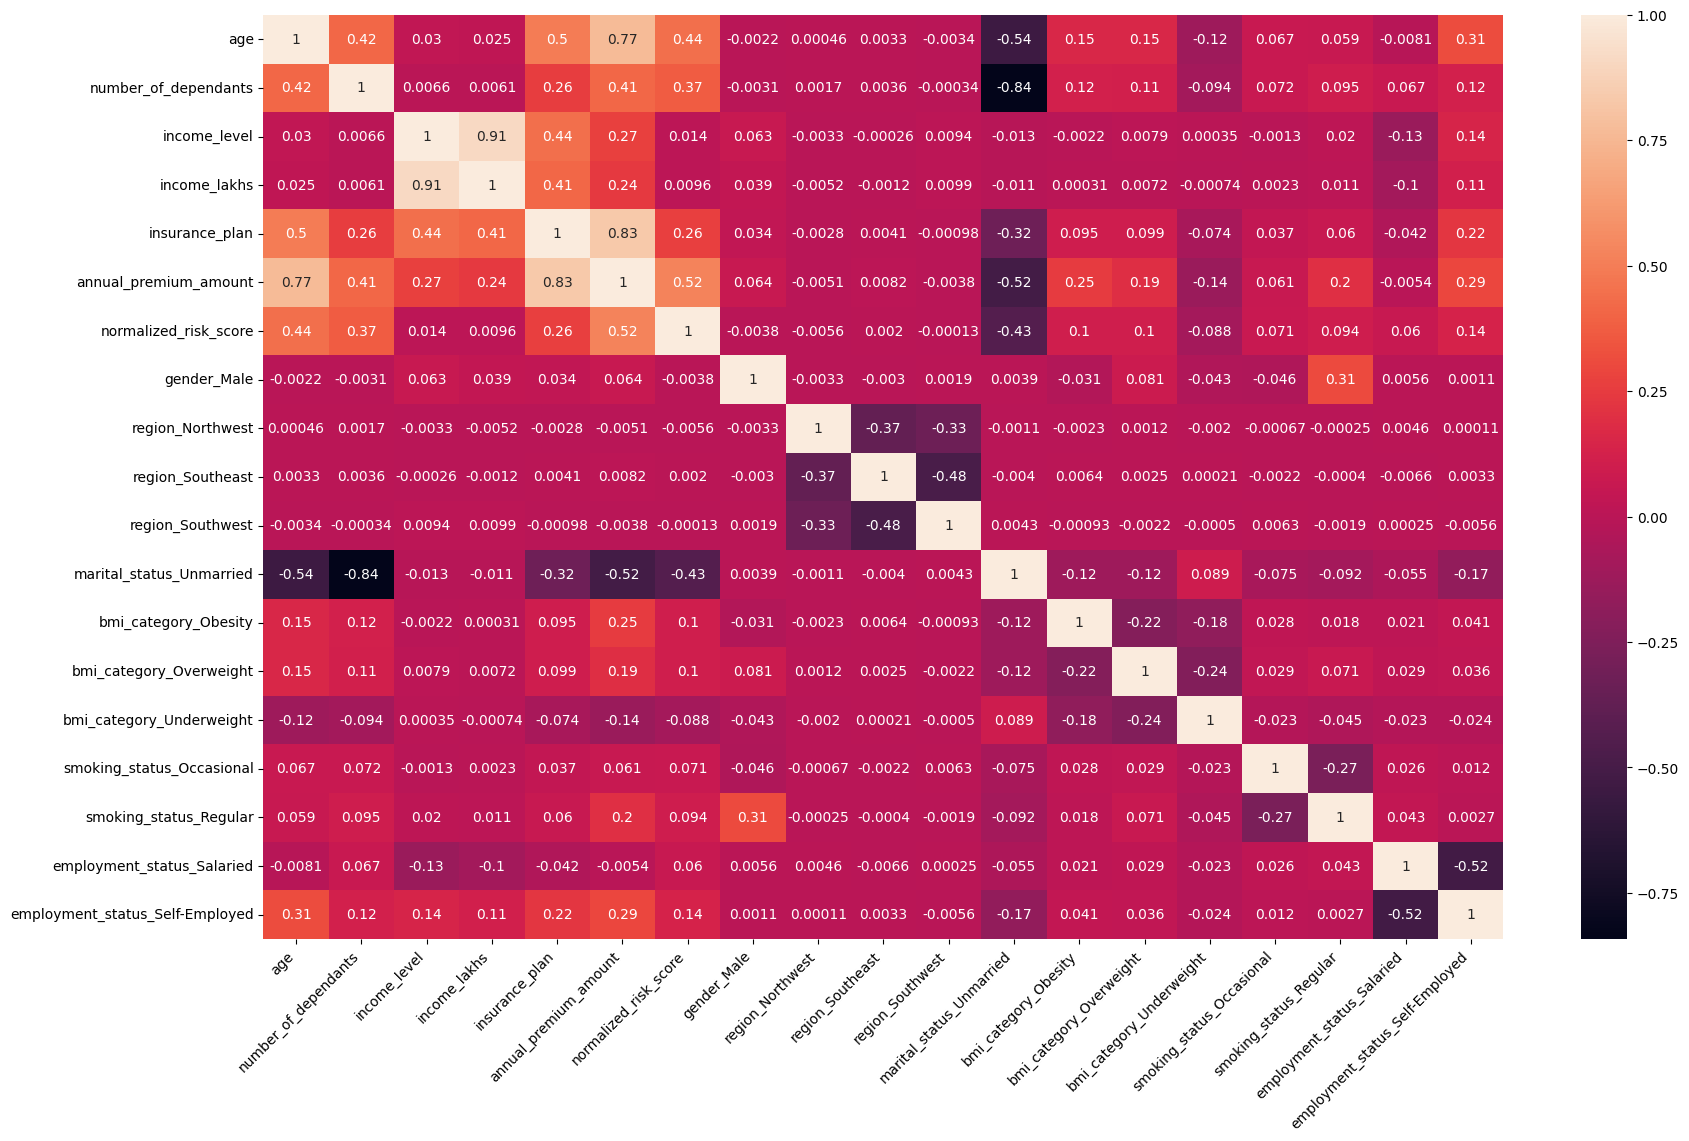

In [1142]:
cm=df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)
plt.show()

In [1143]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


In [1144]:
print(df4.dtypes)


age                                  int64
number_of_dependants                 int64
income_level                         int64
income_lakhs                         int64
insurance_plan                       int64
annual_premium_amount                int64
normalized_risk_score              float64
gender_Male                          int64
region_Northwest                     int64
region_Southeast                     int64
region_Southwest                     int64
marital_status_Unmarried             int64
bmi_category_Obesity                 int64
bmi_category_Overweight              int64
bmi_category_Underweight             int64
smoking_status_Occasional            int64
smoking_status_Regular               int64
employment_status_Salaried           int64
employment_status_Self-Employed      int64
dtype: object


In [1145]:
df4 = df4.copy()
df4 = df4.apply(pd.to_numeric, errors='coerce')

In [1146]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs','insurance_plan']

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [1147]:
def calculate_vif(data):
    vif_df=pd.DataFrame()
    vif_df['columns']=data.columns
    vif_df['VIF']=[variance_inflation_factor(data.values,i)for i in range(data.shape[1])]
    return vif_df

calculate_vif(X)

,columns,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [1148]:
calculate_vif(X.drop('income_level',axis='columns'))

,columns,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [1149]:
X_reduced=X.drop('income_level',axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


# MODEL TRAINING 

In [1150]:
X_train, X_test, y_train , y_test=train_test_split(X_reduced,y,test_size=0.3,random_state=10)

In [1151]:
model_LR=LinearRegression()
model_LR.fit(X_train,y_train)
test_score = model_LR.score(X_test,y_test)
train_score = model_LR.score(X_train,y_train)
print(f'Train Score :{train_score}')
print(f'Test Score :{test_score}')

Train Score :0.9282143576916762
Test Score :0.9280547230217837


In [1152]:
y_pred =model_LR.predict(X_test)
mse_lr=mean_squared_error(y_test,y_pred)
rmse_lr=np.sqrt(mse_lr)

print("Linear Regression ==> :",mse_lr,"\nrmse:",rmse_lr)

Linear Regression ==> : 5165611.913027984 
rmse: 2272.7982561212916


In [1153]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
3598,0.481481,0.4,0.343434,0.5,0.428571,1,0,1,0,1,0,1,0,0,1,1,0


In [1154]:
model_LR.intercept_

np.float64(4824.300272127108)

In [1155]:
model_LR.coef_ #how much they contribute to the model

array([11160.92646188,  -676.44399066,  -514.22981577, 12557.01293645,
        4810.35770228,   168.64666183,   -35.7192924 ,    39.96512973,
         -24.65292857,  -935.76061134,  3387.91145477,  1599.36226775,
         391.1713038 ,   735.91227798,  2234.8047119 ,   155.9846743 ,
         415.90397305])

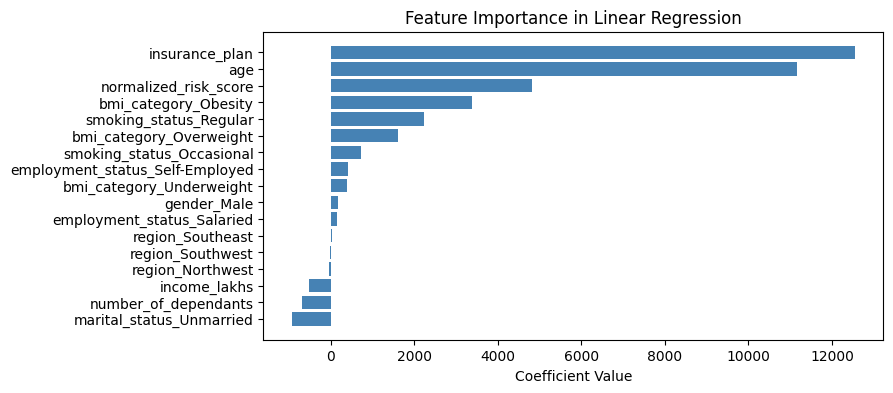

In [1156]:
feature_importances = model_LR.coef_

coef_df= pd.DataFrame(feature_importances, index= X_test.columns,columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients',ascending=True)
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color = 'steelblue')
plt.xlabel("Coefficient Value")
plt.title('Feature Importance in Linear Regression')
plt.show()

In [1157]:
model_rg=Ridge()
model_rg.fit(X_train,y_train)
test_score = model_rg.score(X_test,y_test)
train_score = model_rg.score(X_train,y_train)
print(f'Train Score :{train_score}')
print(f'Test Score :{test_score}')

Train Score :0.9282143198366275
Test Score :0.9280541644640349


In [1158]:
from xgboost import XGBRegressor
model_xg=XGBRegressor()
model_xg.fit(X_train,y_train)
test_score = model_xg.score(X_test,y_test)
train_score = model_xg.score(X_train,y_train)
print(f'Train Score :{train_score}')
print(f'Test Score :{test_score}')

Train Score :0.9860964417457581
Test Score :0.9809534549713135


In [1159]:
y_pred =model_xg.predict(X_test)
mse_lr=mean_squared_error(y_test,y_pred)
rmse_lr=np.sqrt(mse_lr)

print("XGBoost Regression ==> :",mse_lr,"\nrmse:",rmse_lr)

XGBoost Regression ==> : 1367525.625 
rmse: 1169.4125127601467


In [1160]:
param_grid={
    'n_estimators':[20,40,50],
    'learning_rate' : [0.01,0,.1,0.2],
    'max_depth': [3,4,5]
}

random_search= RandomizedSearchCV(model_xg,param_grid,n_iter=10,cv=3,scoring='r2',random_state=10)
random_search.fit(X_train,y_train)
random_search.best_score_

np.float64(0.9816875060399374)

In [1161]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.2}

In [1162]:
best_model = random_search.best_estimator_

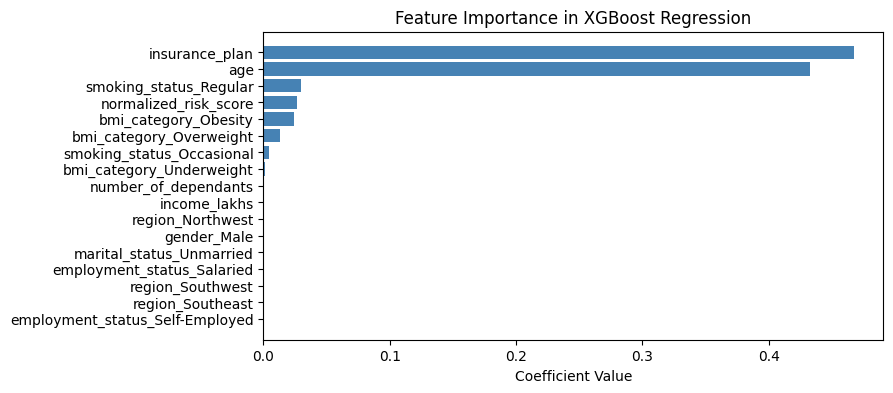

In [1163]:
feature_importances = best_model.feature_importances_

coef_df= pd.DataFrame(feature_importances, index= X_test.columns,columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients',ascending=True)
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color = 'steelblue')
plt.xlabel("Coefficient Value")
plt.title('Feature Importance in XGBoost Regression')
plt.show()

### ERROR ANALYSIS

In [1164]:
y_pred=best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals*100/y_test


results_df=pd.DataFrame({
    'actual':y_test,
    'predicted':y_pred,
    'diff':residuals,
    'diff_pct': residuals_pct
})

results_df

,actual,predicted,diff,diff_pct
3598,20554,20538.167969,-15.832031,-0.077027
35794,29647,29488.517578,-158.482422,-0.534565
43608,20560,20462.074219,-97.925781,-0.476293
42730,5018,7308.584961,2290.584961,45.647369
18936,8929,8257.403320,-671.596680,-7.521522
...,...,...,...,...
5621,18848,18573.574219,-274.425781,-1.455994
6069,6956,6507.043945,-448.956055,-6.454227
21592,8332,10688.078125,2356.078125,28.277462
49274,5571,6767.796875,1196.796875,21.482622


<Axes: xlabel='diff_pct', ylabel='Count'>

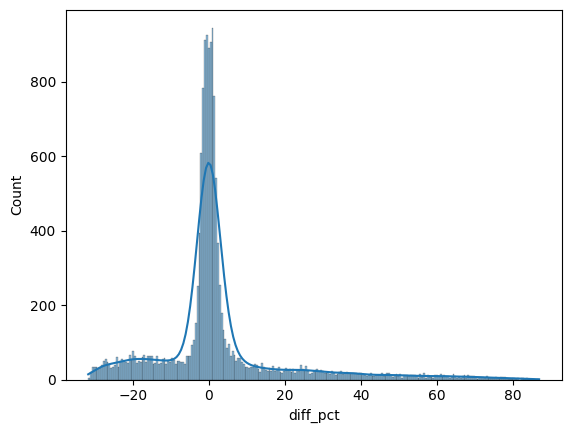

In [1165]:
sns.histplot(results_df['diff_pct'],kde=True)

In [1166]:
extreme_error_threshold=10

extreme_results_df=results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(4407, 4)

In [1167]:
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

29.432979362853136

In [1168]:
results_df[np.abs(results_df.diff_pct)>50].sort_values(by='diff_pct',ascending=False)


,actual,predicted,diff,diff_pct
36269,3501,6539.337402,3038.337402,86.784844
48801,3516,6522.000488,3006.000488,85.494894
42342,3521,6527.288574,3006.288574,85.381669
18564,3523,6527.288574,3004.288574,85.276428
7988,3527,6507.043945,2980.043945,84.492315
...,...,...,...,...
16648,4325,6494.995117,2169.995117,50.173298
13801,4344,6522.000488,2178.000488,50.138133
39329,4527,6796.083984,2269.083984,50.123348
7174,4349,6527.288574,2178.288574,50.087114


In [1169]:
X_test.index

Index([ 3598, 35794, 43608, 42730, 18936, 45416, 20029,  4294, 39145,  3152,
       ...
        4554,  9086,  8767,   603, 25179,  5621,  6069, 21592, 49274, 27977],
      dtype='int64', length=14973)

In [1170]:
extreme_results_df.index

Index([42730, 20029,  4294, 44419,  6707, 11728, 15740, 35065,  9654, 22679,
       ...
       11230,  3036, 36158, 21184, 45020,  8767, 25179, 21592, 49274, 27977],
      dtype='int64', length=4407)

In [1171]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0


In [1172]:
print(X_test.columns.tolist())


['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan', 'normalized_risk_score', 'gender_Male', 'region_Northwest', 'region_Southeast', 'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity', 'bmi_category_Overweight', 'bmi_category_Underweight', 'smoking_status_Occasional', 'smoking_status_Regular', 'employment_status_Salaried', 'employment_status_Self-Employed']


Skipping missing feature: income_level


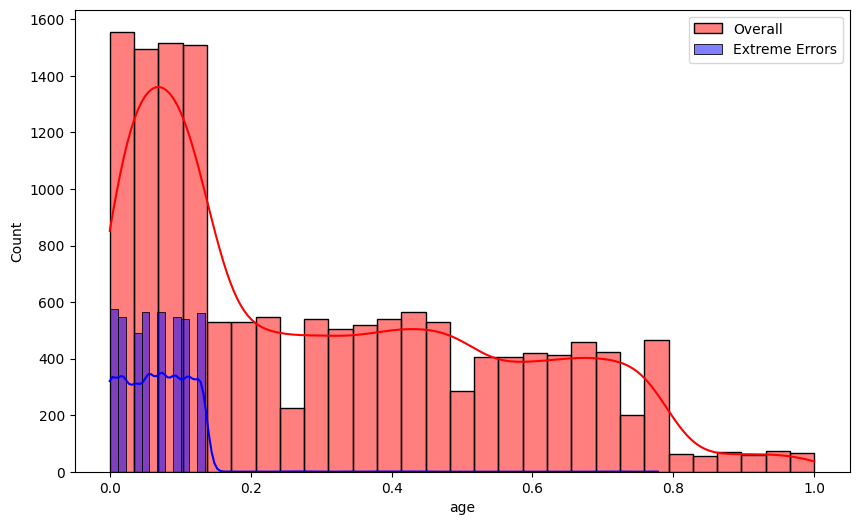

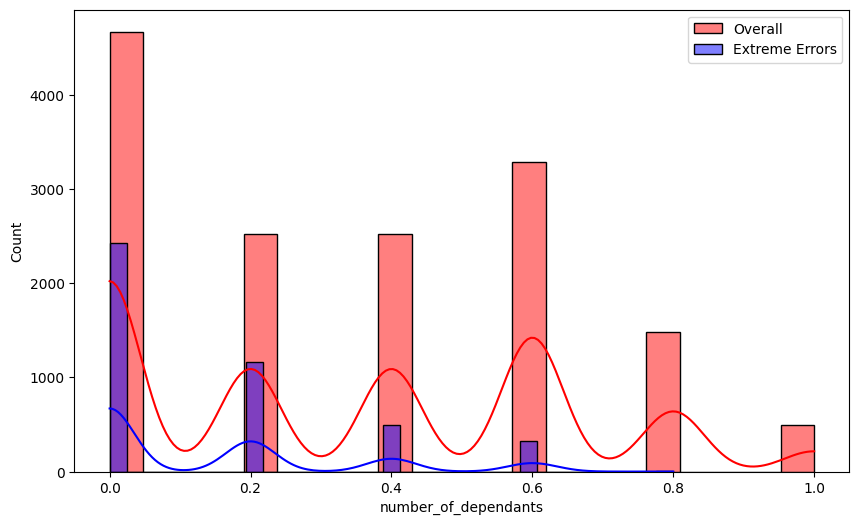

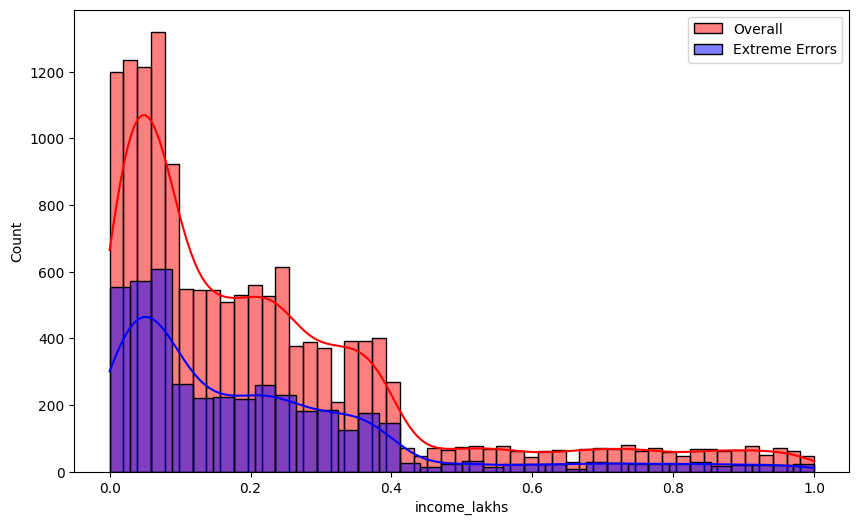

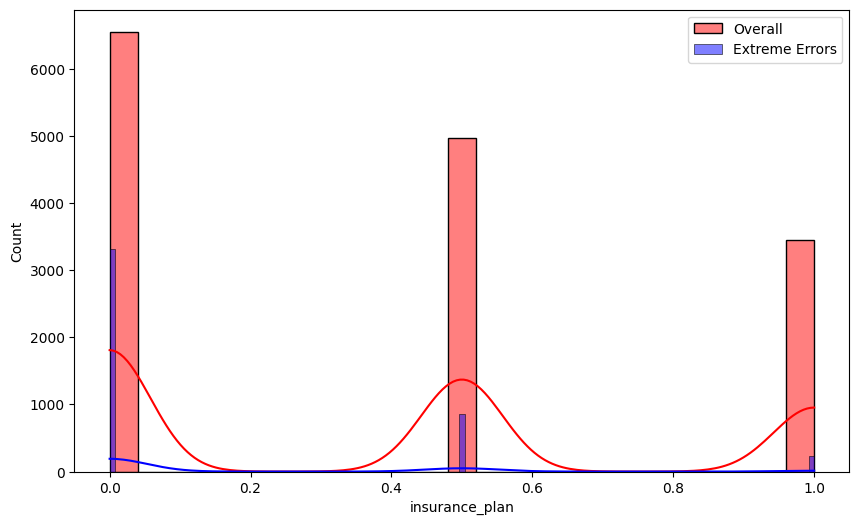

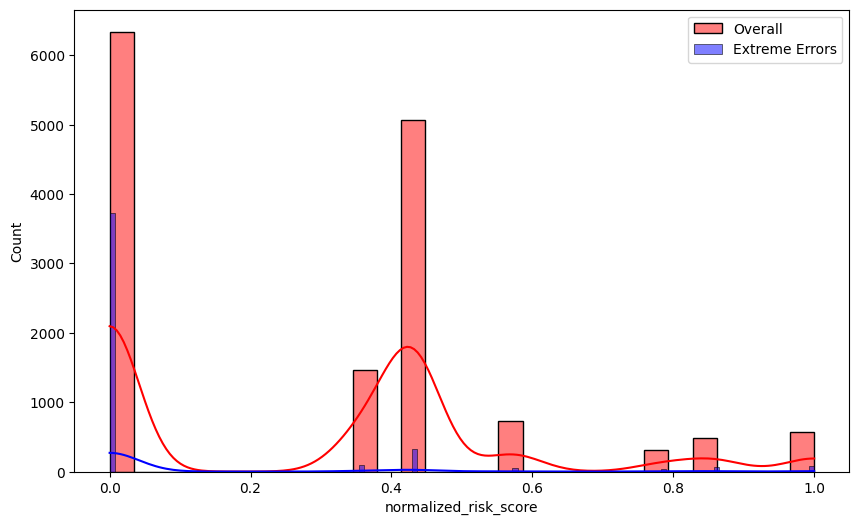

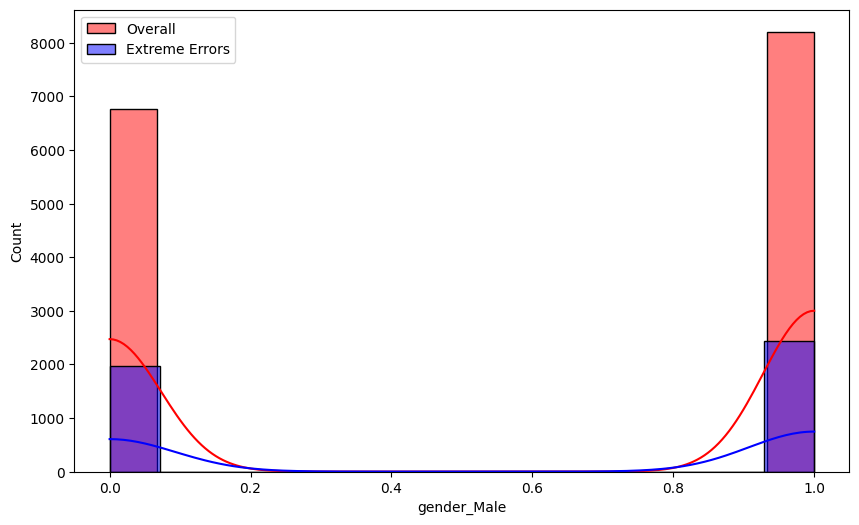

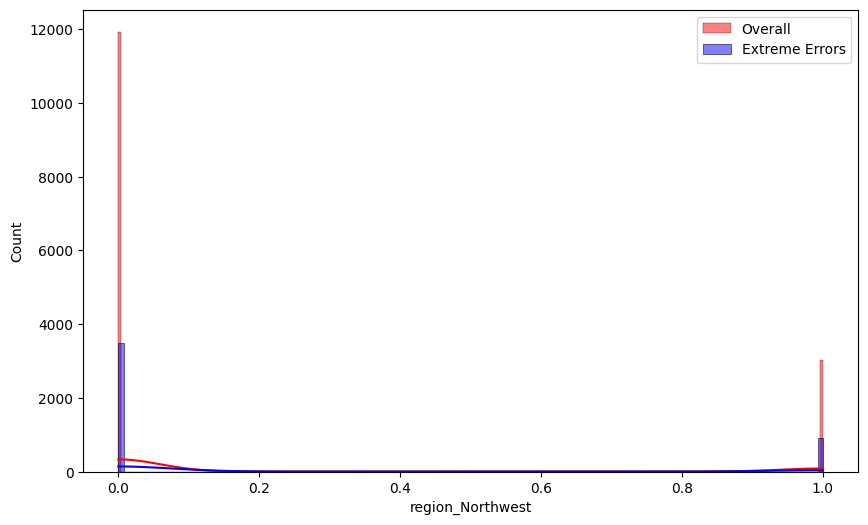

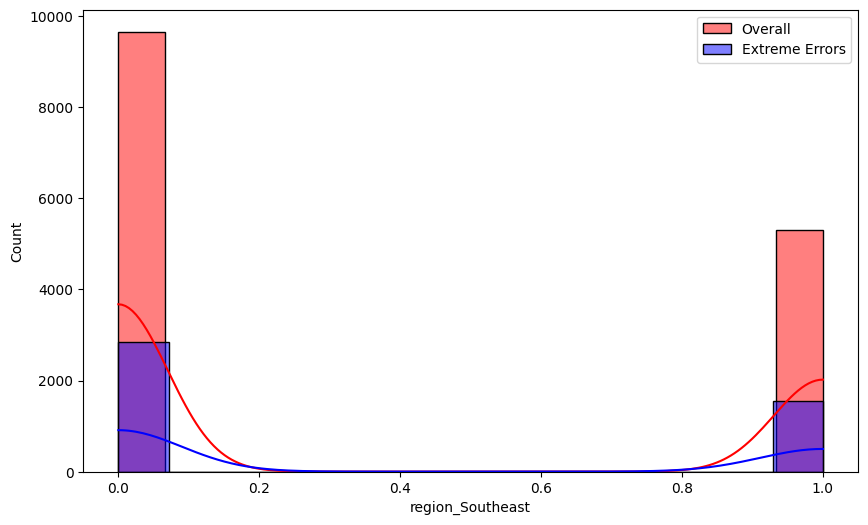

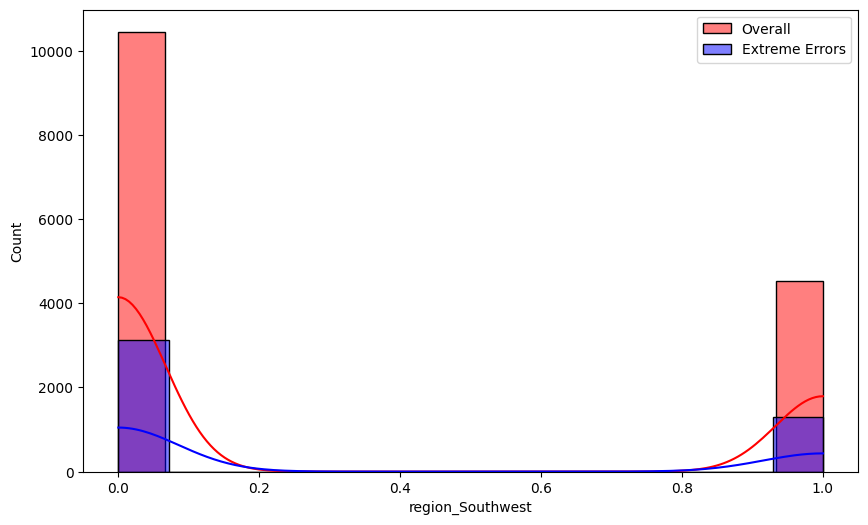

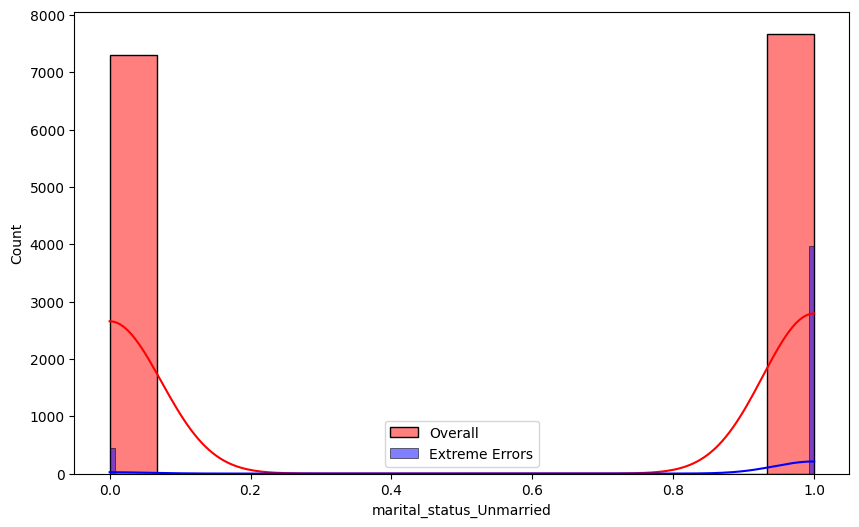

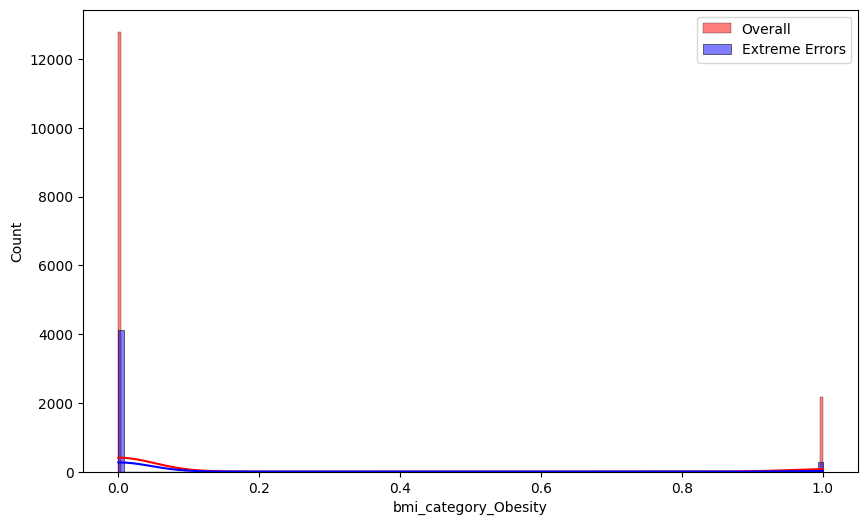

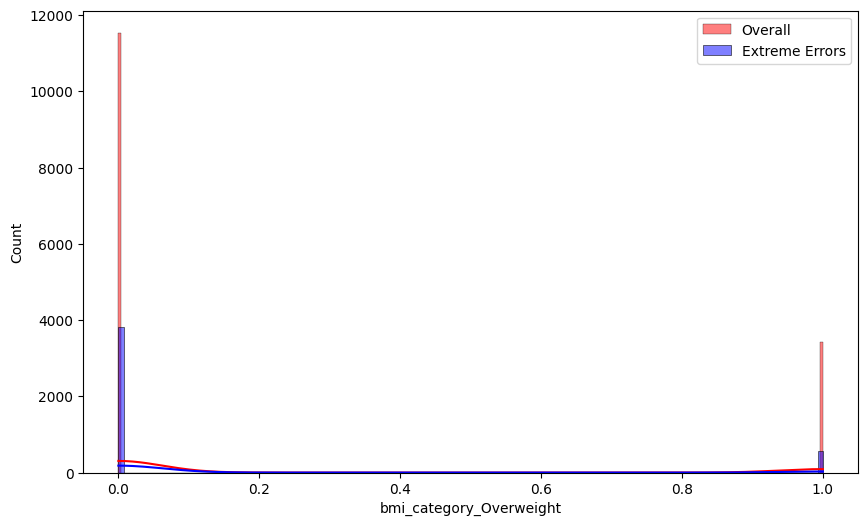

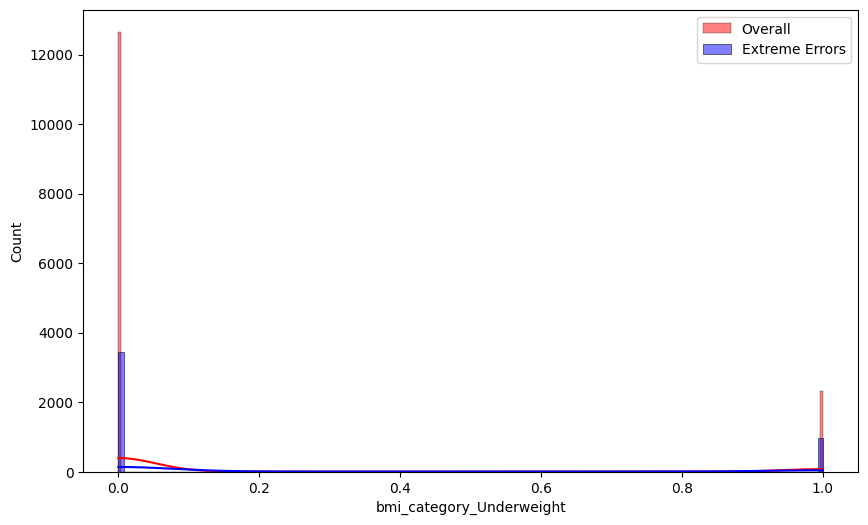

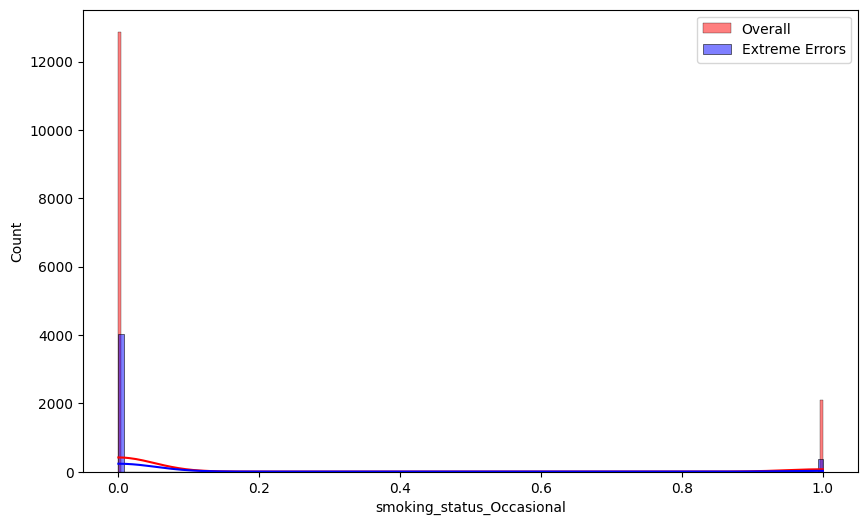

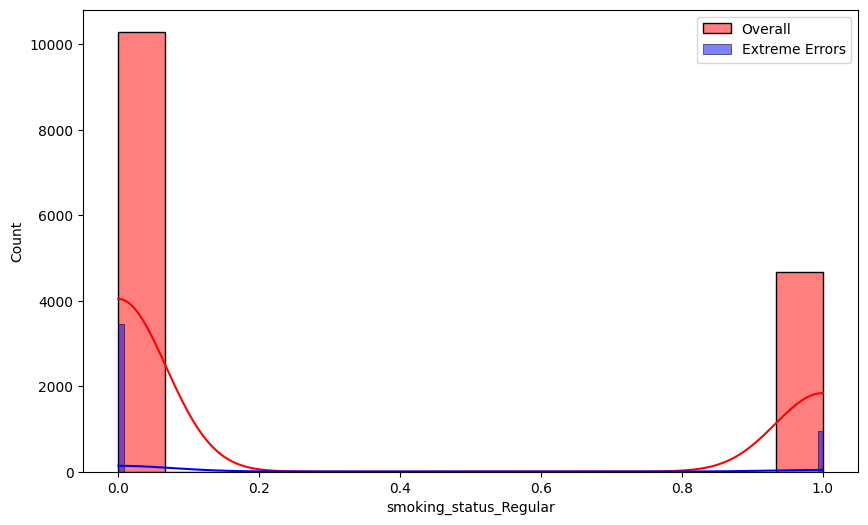

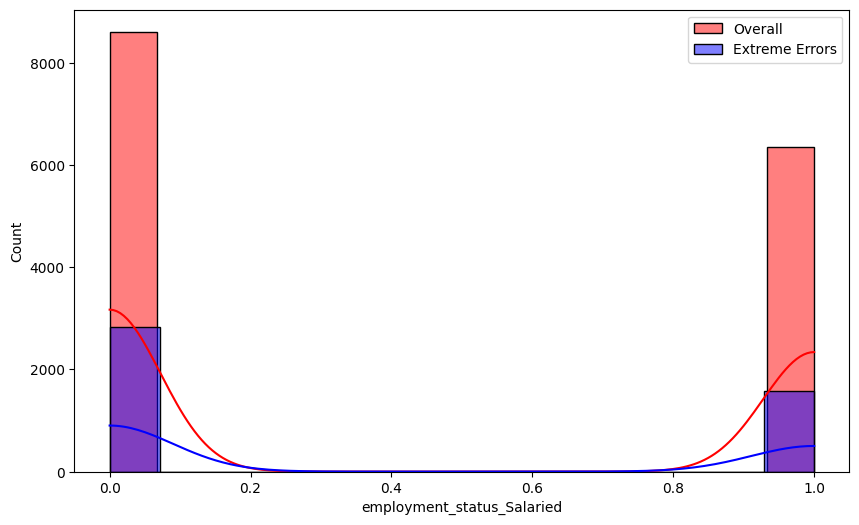

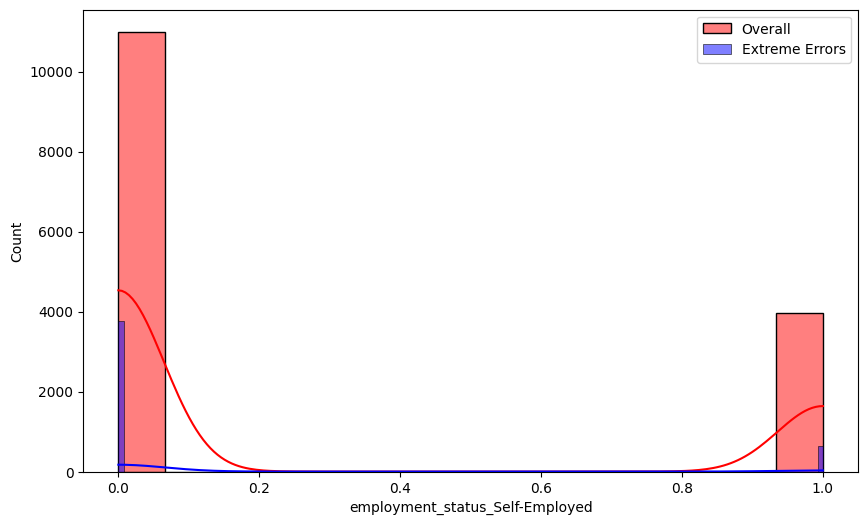

In [1173]:
for feature in X.columns:
    if feature in X_test.columns:
        plt.figure(figsize=(10,6))
        sns.histplot(X_test[feature], color='red', label='Overall', kde=True)
        sns.histplot(extreme_errors_df[feature], color='blue', alpha=0.5, label='Extreme Errors', kde=True)
        plt.legend()
    else:
        print(f"Skipping missing feature: {feature}")


In [1174]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [1177]:
extreme_errors_df['income_level']= -1

<Axes: xlabel='age', ylabel='Count'>

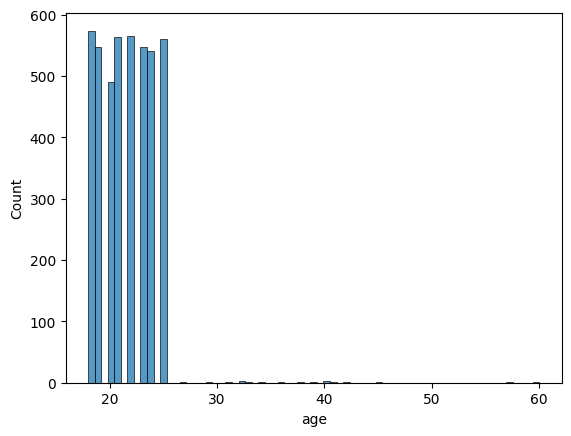

In [1179]:
df_reversed=pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])

sns.histplot(df_reversed['age'])

In [1181]:
for col in categorical_cols:
    print(col, ':', df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : [1 2 4 3]
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : [1 2 3]
